The main code for this project is made using code got from 

In [1]:
import os
import os.path as osp

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import argparse
import matplotlib.pylab as plt

import numpy as np
import random
from datetime import datetime
import copy
from tabulate import tabulate
from tqdm import tqdm

from networks import get_network
from helpers import BuildDataLoader, BuildDataset
from helpers import get_camvid_label, get_cityscapes_label

from core_models import SegmenthorSL
import pytorch_lightning as pl
import torchvision.transforms.functional as transforms_f

/home/nishantn/anaconda3/envs/mmtat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.datasets import Cityscapes
from torchvision import transforms as T
import numpy as np
from tabulate import tabulate
from tqdm import tqdm

## Dataloader

In [5]:

parser = argparse.ArgumentParser(description='Supervised Segmentation with Perfect Labels')

### 1. Data Loading
parser.add_argument('--dataset', default = 'cityscapes688')
parser.add_argument('--train_ul_n', default = None)
parser.add_argument('--pathtomodel', default = None, type=str)

args = parser.parse_args("")

# data_loader_main = BuildDataLoader(dataset=args.dataset)
# print("Defined dataloader for {}".format(args.dataset))

# dataset_info = data_loader_main.build_evaluation()

# test_loader = torch.utils.data.DataLoader(
#             dataset=dataset_info['test'],
#             batch_size=1,
#             shuffle=False,
#             num_workers=4
#             )

# test_dataset = iter(test_loader)
# test_dataset_length = len(test_loader)
data_loader_main = BuildDataLoader(dataset=args.dataset)
clip_dataset = data_loader_main.build_evaluation(apply_transform=False)['test']
ssl_dataset = data_loader_main.build_evaluation()['test']


In [28]:
clip_batch = clip_dataset[20]
ssl_batch = ssl_dataset[20]

image_clip, labels = clip_batch['image'], clip_batch['segmap']
image_ssl, ssl_labels = ssl_batch['image'], ssl_batch['segmap']
image_ssl = image_ssl.unsqueeze(dim=0)

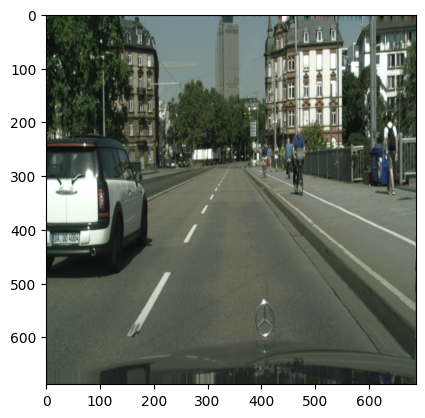

In [46]:
plt.imshow(image_clip)

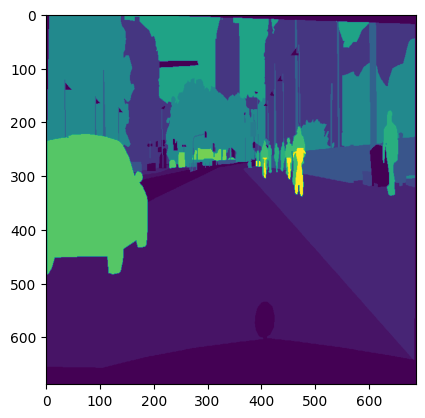

In [30]:
plt.imshow(labels)

In [31]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

working_ckpt = 'last.ckpt'
model = SegmenthorSL.load_from_checkpoint(working_ckpt)

model.to(device)
model.eval()

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clip = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

clip.to(device)
clip.eval()

prompts = ['a photo of a road','a photo of a sidewalk', 'a photo of a building','a photo of a wall', 'a photo of a fence', 'a photo of a pole',
           'a photo of a traffic light', 'a photo of a traffic sign', 'a photo of vegetation', 'a photo of terrain', 'a photo of sky', 
           'a photo of a pedestrian', 'a photo of a rider', 'a photo of a car', 'a photo of a truck', 'a photo of a bus', 'a photo of a choo-choo train', 
       'a photo of a motorcycle', 'a photo of a bicycle']

Global seed set to 3108


In [33]:
with torch.no_grad():
    ssl_outputs = model(image_ssl.to(device))
if isinstance(ssl_outputs, tuple):
    ssl_predictions = ssl_outputs[0]
else:
    ssl_predictions = ssl_outputs
ssl_predictions = F.interpolate(ssl_predictions, size = ssl_labels.unsqueeze(dim=0).shape[1:], mode='bilinear', align_corners=True)
ssl_predictions = F.softmax(ssl_predictions, dim = 1)
confidences, ssl_out = torch.max(ssl_predictions, dim=1)

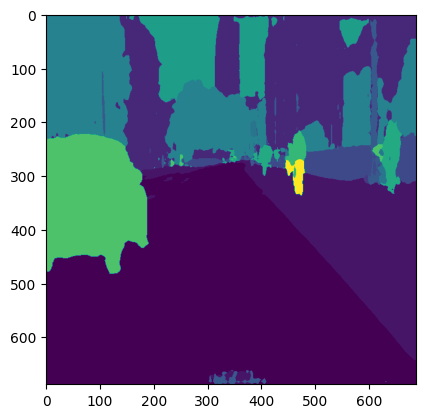

In [36]:
plt.imshow(ssl_out.squeeze().cpu().numpy())

In [37]:
inputs = processor(text=prompts, images=[image_clip] * len(prompts), padding="max_length", return_tensors="pt")
inputs.to(device)
# predict
with torch.no_grad():
    outputs = clip(**inputs)
preds = outputs.logits.unsqueeze(1)
# resize the outputs
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image_clip.size[1], image_clip.size[0]),
    mode="bilinear"
)
clip_predictions = F.softmax(preds.squeeze(), dim = 0)
conf, inds = torch.max(clip_predictions.unsqueeze(dim=0), dim=1)

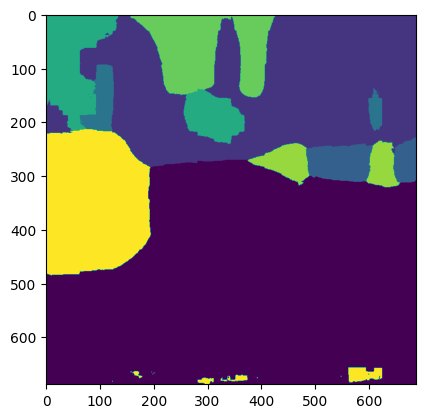

In [38]:
plt.imshow(inds.squeeze().cpu().numpy())

In [39]:
ssl_predictions = ssl_predictions.squeeze()
#print(ssl_predictions)
#predictions = np.array([clip_predictions.cpu(), ssl_predictions.cpu()])
torch_pred = torch.stack([clip_predictions, ssl_predictions])
#weights = [0.5,0.5]
weights = torch.tensor([0.2, 0.8])
weights = weights.to(device)
#weighted_preds = np.tensordot(predictions, weights, axes=((0),(0)))

weighted_preds_torch = torch.tensordot(torch_pred, weights, dims=([0],[0]))
# weighted_ensemble_preds = np.argmax(weighted_preds, axis=0)
confidences, preds = torch.max(weighted_preds_torch.unsqueeze(dim=0), dim=1)

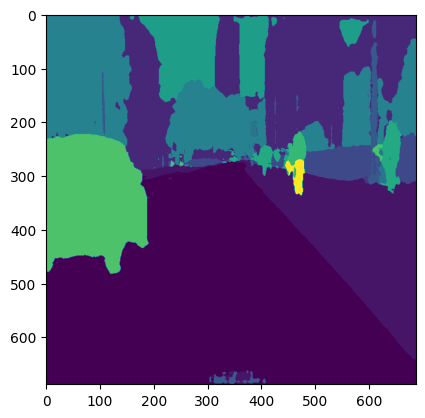

In [40]:
plt.imshow(preds.squeeze().cpu().numpy())

In [44]:
ssl_out[0][0][0]

tensor(8, device='cuda:0')

In [103]:
labels.max()

tensor(13)

In [104]:
labels[labels==-1] = 99
labels

tensor([[99, 99, 99,  ..., 99, 99, 99],
        [99, 99, 99,  ..., 99, 99, 99],
        [99, 99, 99,  ..., 99, 99, 99],
        ...,
        [99, 99, 99,  ..., 99, 99, 99],
        [99, 99, 99,  ..., 99, 99, 99],
        [99, 99, 99,  ..., 99, 99, 99]])

In [105]:
    labels = labels.to(torch.uint8)

TypeError: Image data of dtype object cannot be converted to float

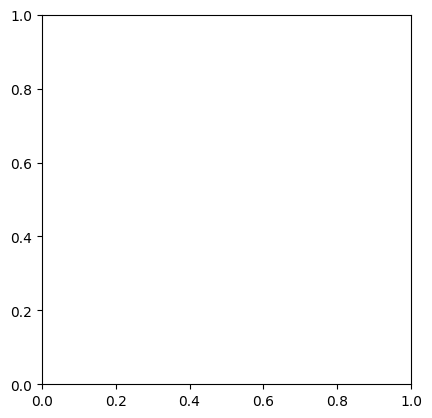

In [112]:
plt.imshow(labels)

In [106]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
segmap = SegmentationMapsOnImage(np.array(labels), img.size)
labels = segmap.resize([2048,1024], interpolation="nearest")
img = img.resize([2048,1024])


In [107]:
import math
def bl_resize(original_img, new_h, new_w):
	#get dimensions of original image
	old_h, old_w, c = original_img.shape
	#create an array of the desired shape. 
	#We will fill-in the values later.
	resized = np.zeros((new_h, new_w, c))
	#Calculate horizontal and vertical scaling factor
	w_scale_factor = (old_w ) / (new_w ) if new_h != 0 else 0
	h_scale_factor = (old_h ) / (new_h ) if new_w != 0 else 0
	for i in range(new_h):
		for j in range(new_w):
			#map the coordinates back to the original image
			x = i * h_scale_factor
			y = j * w_scale_factor
			#calculate the coordinate values for 4 surrounding pixels.
			x_floor = math.floor(x)
			x_ceil = min( old_h - 1, math.ceil(x))
			y_floor = math.floor(y)
			y_ceil = min(old_w - 1, math.ceil(y))

			if (x_ceil == x_floor) and (y_ceil == y_floor):
				q = original_img[int(x), int(y), :]
			elif (x_ceil == x_floor):
				q1 = original_img[int(x), int(y_floor), :]
				q2 = original_img[int(x), int(y_ceil), :]
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)
			elif (y_ceil == y_floor):
				q1 = original_img[int(x_floor), int(y), :]
				q2 = original_img[int(x_ceil), int(y), :]
				q = (q1 * (x_ceil - x)) + (q2	 * (x - x_floor))
			else:
				v1 = original_img[x_floor, y_floor, :]
				v2 = original_img[x_ceil, y_floor, :]
				v3 = original_img[x_floor, y_ceil, :]
				v4 = original_img[x_ceil, y_ceil, :]

				q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
				q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)

			resized[i,j,:] = q
	return resized.astype(np.uint8)

In [183]:
img = Image.open('test.jpg')
img = bl_resize(np.array(img), 512,512)

In [264]:
img.shape

torch.Size([3, 688, 688])

In [228]:
img = img.resize([688,688])

## CLIP 

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")



In [36]:
# prompts = ['road','sidewalk', 'building','wall', 'fence', 'pole','traffic light', 'traffic sign', 
#            'vegetation', 'terrain', 'sky', 'pedestrian', 'rider', 'car', 'truck', 'bus', 'train', 
#            'motorcycle', 'bicycle']
prompts = ['a photo of a road','a photo of a sidewalk', 'a photo of a building','a photo of a wall', 'a photo of a fence', 'a photo of a pole',
           'a photo of a traffic light', 'a photo of a traffic sign', 'a photo of vegetation', 'a photo of terrain', 'a photo of sky', 
           'a photo of a pedestrian', 'a photo of a rider', 'a photo of a car', 'a photo of a truck', 'a photo of a bus', 'a photo of a locomotive', 
       'a photo of a motorcycle', 'a photo of a bicycle']
# prompts = ['road', 'person']

In [37]:
# im = np.array(img_r
# img = img.squeeze()
inputs = processor(text=prompts, images=[img] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
    outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

# resize the outputs
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(img.size[1], img.size[0]),
    mode="bilinear"
)

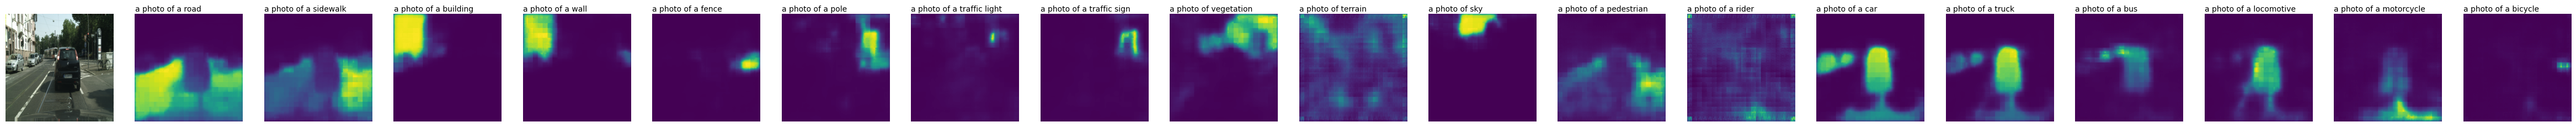

In [38]:
len_cats = len(prompts)
_, ax = plt.subplots(1, len_cats + 1, figsize=(3*(len_cats + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(img)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len_cats)];
[ax[i+1].text(0, -15, category_name) for i, category_name in enumerate(prompts)];

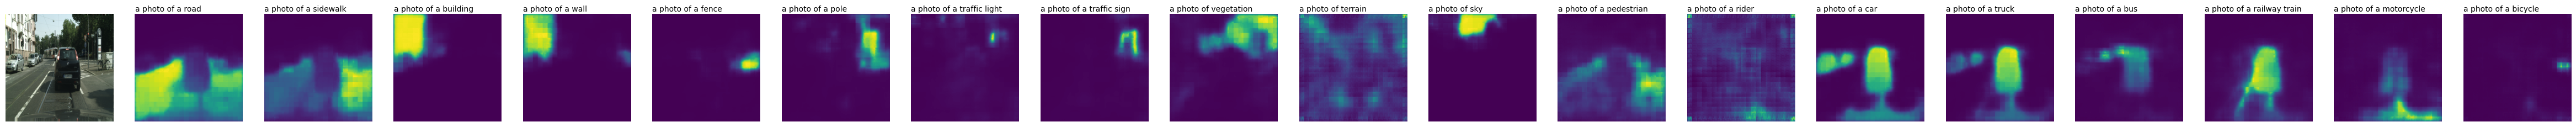

In [24]:
len_cats = len(prompts)
_, ax = plt.subplots(1, len_cats + 1, figsize=(3*(len_cats + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(img)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len_cats)];
[ax[i+1].text(0, -15, category_name) for i, category_name in enumerate(prompts)];

In [25]:
preds.shape

torch.Size([19, 1, 688, 688])

In [39]:
threshold = 0.1
flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0], flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[:preds.shape[0],:] = flat_preds
# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))
inds.shape

torch.Size([688, 688])

In [40]:
np.unique(inds)

array([ 0,  1,  2,  3,  4,  5,  7,  8, 10, 13, 14])

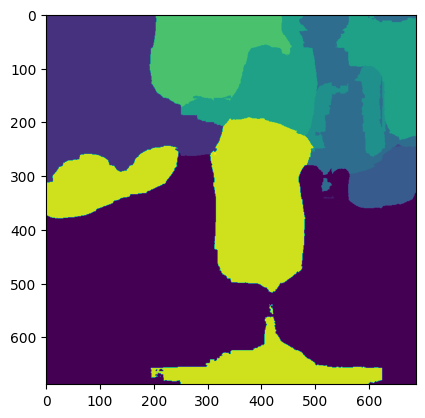

In [41]:
plt.imshow(inds)

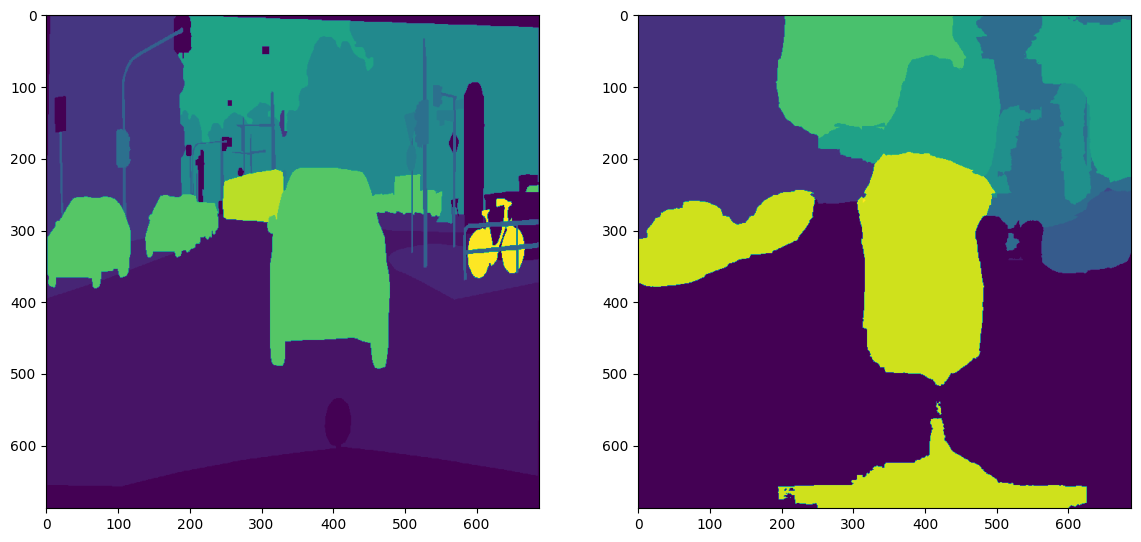

In [35]:
_, ax = plt.subplots(1, 2, figsize = (14,7))
ax[0].imshow(np.array(labels))
ax[1].imshow(inds)

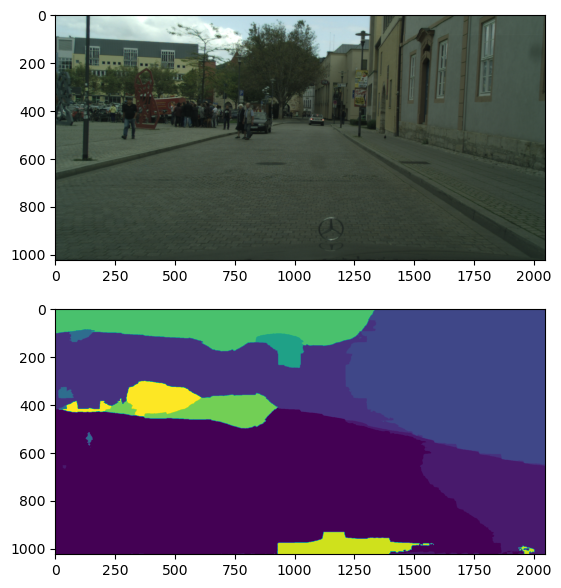

In [32]:
_, ax = plt.subplots(2, 1, figsize = (7,7))
ax[0].imshow(img)
ax[1].imshow(inds)

In [98]:
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
# You can comment out this line if you are passing tensors of equal shape
# But if you are passing output from UNet or something it will most probably
  # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

    intersection = (torch.logical_and(outputs, labels)).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (torch.logical_or(outputs, labels)).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.7), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [99]:
iou_pytorch(inds, T.ToTensor()(label))

tensor([0.5000])

In [100]:
i = T.ToPILImage()(label)
print(i.size)
i.save("OG.jpg")

(2048, 1024)


In [101]:
print(inds.shape)
img = Image.fromarray((inds).numpy().astype(np.uint8))#.transpose(1,0))
print(img.size)
img.save("pred.jpg")

torch.Size([1024, 2048])
(2048, 1024)


In [16]:
def get_cityscapes_label():
    mask_labels = {0: 'road',
                   1: 'sidewalk',
                   2: 'building',
                   3: 'wall',
                   4: 'fence',
                   5: 'pole',
                   6: 'traffic light',
                   7: 'traffic sign',
                   8: 'vegetation',
                   9: 'terrain',
                   10: 'sky',
                   11: 'pedestrian',
                   12: 'rider',
                   13: 'car',
                   14: 'truck',
                   15: 'bus',
                   16: 'train',
                   17: 'motorcycle',
                   18: 'bicycle'
                   }
    return mask_labels

def fast_hist(pred, gtruth, num_classes):
    # mask indicates pixels we care about
    mask = (gtruth >= 0) & (gtruth < num_classes)

    # stretch ground truth labels by num_classes
    #   class 0  -> 0
    #   class 1  -> 19
    #   class 18 -> 342
    #
    # TP at 0 + 0, 1 + 1, 2 + 2 ...
    #
    # TP exist where value == num_classes*class_id + class_id
    # FP = row[class].sum() - TP
    # FN = col[class].sum() - TP
    hist = np.bincount(num_classes * gtruth[mask].astype(int) + pred[mask],
                       minlength=num_classes ** 2)
    hist = hist.reshape(num_classes, num_classes)
    return hist

# -----------------------------------------------------------------------------
# Ref: https://github.com/NVIDIA/semantic-segmentation
# -----------------------------------------------------------------------------

def calculate_iou(hist_data):
    # acc = np.diag(hist_data).sum() / hist_data.sum()
    acc_cls = np.diag(hist_data) / (hist_data.sum(axis=1) + 1e-10)
    acc_cls = np.nanmean(acc_cls)
    divisor = hist_data.sum(axis=1) + hist_data.sum(axis=0) - np.diag(hist_data)
    iou = np.diag(hist_data) / (divisor + 1e-10)
    return iou, acc_cls

# -----------------------------------------------------------------------------
# Ref: https://github.com/NVIDIA/semantic-segmentation
# (Slightly modified)
# -----------------------------------------------------------------------------

def get_stats(hist, iu):
    
    iu_FP = hist.sum(axis=1) - np.diag(hist)
    iu_FN = hist.sum(axis=0) - np.diag(hist)
    iu_TP = np.diag(hist)
    

    id2cat = get_cityscapes_label()
        
    tabulate_data = []
    
    header = ['Id', 'label', 'iU']
    header.extend(['Precision', 'Recall'])
    
    for class_id in range(len(iu)):
        class_data = []
        class_data.append(class_id)
        class_name = "{}".format(id2cat[class_id]) if class_id in id2cat else ''
        class_data.append(class_name)
        class_data.append(iu[class_id] * 100)
    
        # total_pixels = hist.sum()
        class_data.append((iu_TP[class_id] / (iu_TP[class_id] + iu_FP[class_id])) * 100)
        class_data.append((iu_TP[class_id] / (iu_TP[class_id] + iu_FN[class_id])) * 100)
        tabulate_data.append(class_data)
        
    print_str = str(tabulate((tabulate_data), headers=header, floatfmt='1.2f'))
    print(print_str)
    print("mIoU = {:.2f}".format(np.nanmean(iu) * 100))


In [19]:
hist = fast_hist(pred=inds.flatten().cpu().numpy(),
                              gtruth=labels.flatten().cpu().numpy(),
                              num_classes=19)
iu, _ = calculate_iou(hist)
get_stats(hist, iu)

  Id  label             iU    Precision    Recall
----  -------------  -----  -----------  --------
   0  road           88.61        96.20     91.83
   1  sidewalk       53.82        66.03     74.44
   2  building       85.65        93.10     91.46
   3  wall            0.00       nan       nan
   4  fence           0.00         0.00      0.00
   5  pole            4.86         7.85     11.30
   6  traffic light   0.00       nan         0.00
   7  traffic sign    0.00         0.00    nan
   8  vegetation      0.00         0.00    nan
   9  terrain         0.00       nan       nan
  10  sky            72.26        90.66     78.07
  11  pedestrian      0.00         0.00      0.00
  12  rider           0.00       nan       nan
  13  car            72.37        95.60     74.86
  14  truck           0.00       nan         0.00
  15  bus             0.00       nan       nan
  16  train           0.00       nan       nan
  17  motorcycle      0.00       nan       nan
  18  bicycle         0.

/tmp/ipykernel_564810/1260781805.py:82: RuntimeWarning: invalid value encountered in scalar divide
  class_data.append((iu_TP[class_id] / (iu_TP[class_id] + iu_FP[class_id])) * 100)


In [140]:


hist = 0

for i in tqdm(range(len(testset))):
    
    img, smnt = testset[i]
    label = T.ToTensor()(cityscapes_class_map(np.array(smnt)))
    inputs = processor(text=prompts, images=[img] * len(prompts), padding="max_length", return_tensors="pt")
    # predict
    inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    preds = outputs.logits.unsqueeze(1)

    # resize the outputs
    preds = nn.functional.interpolate(
        outputs.logits.unsqueeze(1),
        size=(img.size[1], img.size[0]),
        mode="bilinear"
    )
    
    threshold = 0.1
    flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

    # Initialize a dummy "unlabeled" mask with the threshold
    flat_preds_with_treshold = torch.full((preds.shape[0], flat_preds.shape[-1]), threshold)
    flat_preds_with_treshold[:preds.shape[0],:] = flat_preds
    # Get the top mask index for each pixel
    inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))


    _hist = fast_hist(pred=inds.flatten().cpu().numpy(),
                          gtruth=label.flatten().cpu().numpy(),
                          num_classes=19)
    hist += _hist

iu, _ = calculate_iou(hist)

get_stats(hist, iu, dataset = args.dataset)

torch.cuda.empty_cache()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1525/1525 [44:15<00:00,  1.74s/it]


NameError: name 'args' is not defined

In [141]:
get_stats(hist, iu)

  Id  label            iU    Precision    Recall
----  -------------  ----  -----------  --------
   0  road           0.00       nan         0.00
   1  sidewalk       3.93         3.93    100.00
   2  building       0.00       nan         0.00
   3  wall           0.00       nan         0.00
   4  fence          0.00       nan         0.00
   5  pole           0.00       nan         0.00
   6  traffic light  0.00       nan         0.00
   7  traffic sign   0.00       nan         0.00
   8  vegetation     0.00       nan         0.00
   9  terrain        0.00       nan         0.00
  10  sky            0.00       nan         0.00
  11  pedestrian     0.00       nan         0.00
  12  rider          0.00       nan         0.00
  13  car            0.00       nan         0.00
  14  truck          0.00       nan         0.00
  15  bus            0.00       nan         0.00
  16  train          0.00       nan         0.00
  17  motorcycle     0.00       nan         0.00
  18  bicycle       

/tmp/ipykernel_150385/1260781805.py:82: RuntimeWarning: invalid value encountered in long_scalars
  class_data.append((iu_TP[class_id] / (iu_TP[class_id] + iu_FP[class_id])) * 100)


In [ ]:
from helpers import BuildDataLoader, BuildDataset
data_loader_main = BuildDataLoader(dataset=cityscapes688)
dataset_info = data_loader_main.build_supervised(args)